In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from typing import List, Union, Optional, Callable
import pickle
from Bio import AlignIO, SeqIO
from ete3 import Tree, TreeNode
from gctree import CollapsedTree

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from ete3 import Tree, faces, TreeStyle, NodeStyle, TextFace, SequenceFace, COLOR_SCHEMES, CircleFace
from GCTree_preparation import *
import warnings
import math
import nltk

warnings.filterwarnings("ignore")

path_to_storage = "/media/hieunguyen/HNHD01/storage/all_BSimons_datasets"
outdir = "/media/hieunguyen/GSHD_HN01/outdir/sc_bulk_BCR_data_analysis_v0.1"

bulk_project = "240826_BSimons"
sc_project = "240805_BSimons"
PROJECTS = f"{bulk_project}_{sc_project}"

path_to_01_output = f"{outdir}/tree_analysis/{bulk_project}/01_output"
path_to_06_output = f"{outdir}/tree_analysis/06_output/{PROJECTS}"
os.system(f"mkdir -p {path_to_06_output}")

with open(f"{path_to_01_output}/saveTreeobj.pkl", "rb") as f:
    saveTreeobj = pickle.load(f)

mouseid = "m1"

bulk_metadata = pd.read_excel("/media/hieunguyen/HNSD01/src/sc_bulk_BCR_data_analysis/preprocessing/240826_BSimons/240829 sample sheet.xlsx")
bulk_metadata.columns = ["MID", "mouseID", "organ", "population"]

maindf = pd.read_csv(f"{path_to_01_output}/tree_summarydf.csv")
maindf = maindf[maindf["mouseID"] == mouseid]

path_to_04_output = os.path.join(outdir, "VDJ_output", "04_output")
thres = 0.85
clonedf = pd.read_csv(os.path.join(path_to_04_output, "full_clonedf_with_mutation_rate.csv"), index_col= [0])
clonedf = clonedf[clonedf['num_mutation'] != "region_not_covered-skip"]

sc_clonedf = clonedf[clonedf['dataset.name'] == sc_project][["barcode", "id", 'V.gene', 'J.gene', 'D.gene', "aaSeqCDR3", "nSeqCDR3"]].reset_index().drop("index", axis = 1)

# path_to_clonesets = f"{outdir}/VDJ_output/03_output/FASTA_output/{bulk_project}/VDJ_output_{thres}/{mouseid}/all/clonesets.csv"
# bulk_clonedf = pd.read_csv(path_to_clonesets)[["id", 'V.gene', 'J.gene', 'D.gene', f'VJcombi_CDR3_{thres}', "aaSeqCDR3", "nSeqCDR3"]]
# bulk_clonedf.columns = ["id", 'V.gene', 'J.gene', 'D.gene', "cloneid", "aaSeqCDR3", "nSeqCDR3"]
# bulk_clonedf["mouseID"] = bulk_clonedf["id"].apply(lambda x: bulk_metadata[bulk_metadata["MID"] == x]["mouseID"].values[0])
# bulk_clonedf = bulk_clonedf[bulk_clonedf["mouseID"] == mouseid]

sc_clonedf["mouseID"] = sc_clonedf["id"].apply(lambda x: "m" + x.replace("M", "").replace("P", ""))
sc_clonedf = sc_clonedf[sc_clonedf["mouseID"] == mouseid]


/home/hieunguyen/miniconda3/envs/ete3_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
color_path = f"{bulk_project}_color.csv"
tree_dist_seqdf = pd.DataFrame()

for cloneid in tqdm(maindf.cloneid.unique()):
    V_gene = cloneid.split("_")[1]
    J_gene = cloneid.split("_")[2]
    cdr3_len = cloneid.split("_")[3]
    mouseid = cloneid.split("_")[0]

    treeobj = saveTreeobj[cloneid]
    seqdf = treeobj.seqdf.copy()
    idmapdf = treeobj.idmapseqdf.copy()
    bulkdf = seqdf.merge(idmapdf, right_on = "seq", left_on = "seq")
    bulkdf["aaSeqCDR3"] = bulkdf["ID"].apply(lambda x: x.split("|")[2].split(":")[1])

    scdf = sc_clonedf[(sc_clonedf["V.gene"] == V_gene.split("-0")[0]) & 
                    (sc_clonedf["J.gene"] == J_gene.split("-0")[0])]

    scdf["len"] = scdf["nSeqCDR3"].apply(lambda x: len(x))
    scdf = scdf[scdf["len"] == int(cdr3_len)]

    if scdf.shape[0] > 0:
        for i in range(0, scdf.shape[0]):
            barcode = scdf.iloc[i].barcode
            sampleid = scdf.iloc[i].id
            sc_seq = scdf[(scdf["barcode"] == barcode) & (scdf["id"] == sampleid)]["aaSeqCDR3"].values[0] 

            bulkdf[f"{sampleid}_{barcode}"] = bulkdf["aaSeqCDR3"].apply(lambda x: nltk.edit_distance(x, sc_seq)/len(x))
        bulkdf["min_dist_to_a_cell"] = bulkdf[[item for item in bulkdf.columns if sampleid in item]].apply(lambda x: min(x), axis = 1)

        bulkdf = bulkdf[["ID", "seq", "abundance", "MID", "seqid", "min_dist_to_a_cell"]]
        bulkdf["cloneid"] = cloneid
        tree_dist_seqdf = pd.concat([tree_dist_seqdf, bulkdf], axis = 0)

100%|██████████| 396/396 [00:07<00:00, 52.96it/s]


In [39]:
len(tree_dist_seqdf.cloneid.unique())

300

In [3]:
tree_dist_seqdf[tree_dist_seqdf["min_dist_to_a_cell"] == min(tree_dist_seqdf["min_dist_to_a_cell"])].cloneid.unique()

array(['m1_IGHV1-47-01_IGHJ3-01_39_1', 'm1_IGHV1-72-01_IGHJ4-01_45_1',
       'm1_IGHV1-78-01_IGHJ2-01_48_1', 'm1_IGHV1-74-01_IGHJ3-01_39_1',
       'm1_IGHV1-39-01_IGHJ3-01_36_1', 'm1_IGHV8-12-01_IGHJ1-03_57_1',
       'm1_IGHV8-8-01_IGHJ4-01_51_2', 'm1_IGHV13-2-01_IGHJ3-01_42_1',
       'm1_IGHV8-5-01_IGHJ2-01_51_1', 'm1_IGHV1-22-01_IGHJ1-01_48_1',
       'm1_IGHV1-26-01_IGHJ2-01_30_1', 'm1_IGHV1-26-01_IGHJ2-01_33_3',
       'm1_IGHV5-4-01_IGHJ3-01_30_1', 'm1_IGHV1-77-01_IGHJ3-01_39_1',
       'm1_IGHV1-76-01_IGHJ4-01_42_1', 'm1_IGHV1-72-01_IGHJ4-01_51_1',
       'm1_IGHV8-12-01_IGHJ1-03_42_2', 'm1_IGHV1-58-01_IGHJ2-01_39_1',
       'm1_IGHV1-76-01_IGHJ1-03_48_1', 'm1_IGHV1-26-01_IGHJ2-01_42_4',
       'm1_IGHV1-80-01_IGHJ4-01_39_3', 'm1_IGHV14-4-01_IGHJ2-02_33_1',
       'm1_IGHV1-72-01_IGHJ2-01_39_1', 'm1_IGHV1-82-01_IGHJ4-01_30_1',
       'm1_IGHV1-52-01_IGHJ4-01_36_1', 'm1_IGHV4-1-01_IGHJ4-01_45_1',
       'm1_IGHV1-26-01_IGHJ2-01_36_3', 'm1_IGHV1-75-01_IGHJ4-01_39_1',
       'm1

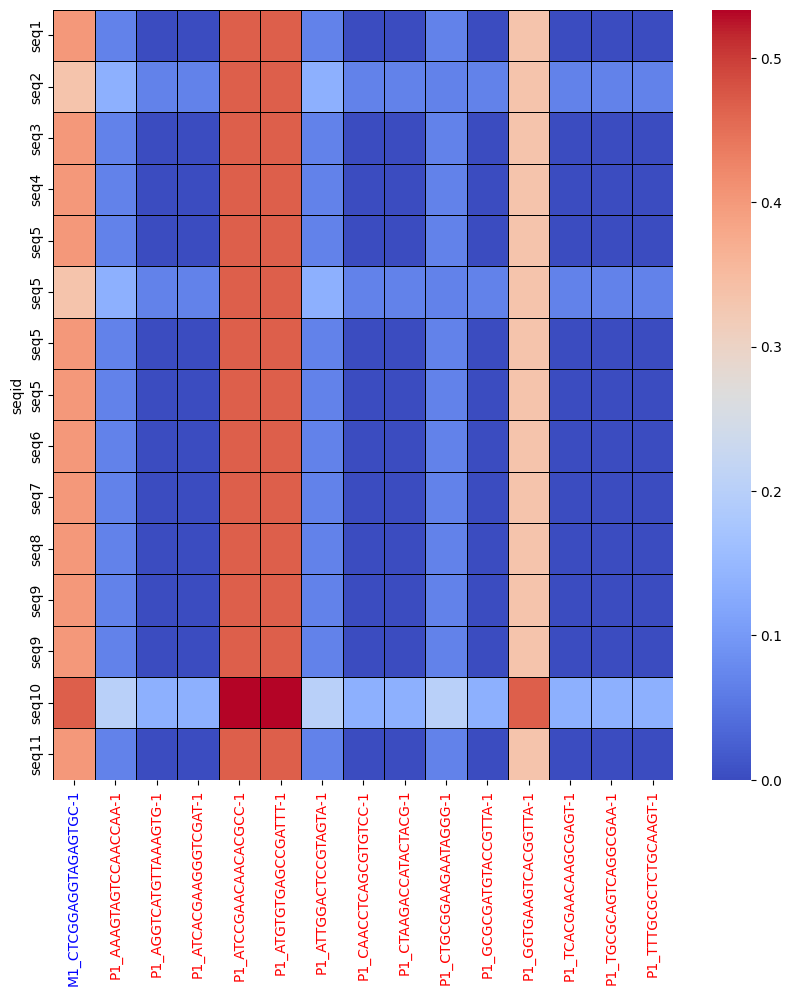

In [ ]:
# cloneid = "m1_IGHV1-47-01_IGHJ3-01_39_1"
cloneid = "m1_IGHV1-72-01_IGHJ4-01_45_1"

V_gene = cloneid.split("_")[1]
J_gene = cloneid.split("_")[2]
cdr3_len = cloneid.split("_")[3]
mouseid = cloneid.split("_")[0]

treeobj = saveTreeobj[cloneid]
seqdf = treeobj.seqdf.copy()
idmapdf = treeobj.idmapseqdf.copy()
bulkdf = seqdf.merge(idmapdf, right_on = "seq", left_on = "seq")
bulkdf["aaSeqCDR3"] = bulkdf["ID"].apply(lambda x: x.split("|")[2].split(":")[1])

scdf = sc_clonedf[(sc_clonedf["V.gene"] == V_gene.split("-0")[0]) & 
                (sc_clonedf["J.gene"] == J_gene.split("-0")[0])]

scdf["len"] = scdf["nSeqCDR3"].apply(lambda x: len(x))
scdf = scdf[scdf["len"] == int(cdr3_len)]

if scdf.shape[0] > 0:
    for i in range(0, scdf.shape[0]):
        barcode = scdf.iloc[i].barcode
        sampleid = scdf.iloc[i].id
        sc_seq = scdf[(scdf["barcode"] == barcode) & (scdf["id"] == sampleid)]["aaSeqCDR3"].values[0] 

        bulkdf[f"{sampleid}_{barcode}"] = bulkdf["aaSeqCDR3"].apply(lambda x: nltk.edit_distance(x, sc_seq)/len(x))
    bulkdf["min_dist_to_a_cell"] = bulkdf[[item for item in bulkdf.columns if sampleid in item]].apply(lambda x: min(x), axis = 1)

# ts = treeobj.generate_tree_style_with_dist(
#     bulkdf = bulkdf,
#     hex_min = "0d0887",
#     hex_max = "f89540",
#     dist_to_cell = "M1_AACACGTCATACAGCT-1")
# treeobj.tree.render(f"%%inline", tree_style = ts)
# plt.show()

plt.figure(figsize= (10, 10))
sns.heatmap(bulkdf[["seqid"] + [item for item in bulkdf.columns if "_" in item and item != "min_dist_to_a_cell"]].set_index("seqid"),
            cmap="coolwarm", cbar=-1, linewidths=0.5, linecolor='black')
for tick_label in plt.gca().get_xticklabels():
    tick_text = tick_label.get_text()
    if "M" in tick_text:
        tick_label.set_color('blue')
    elif "P" in tick_text:
        tick_label.set_color('red')
plt.show()